# Variational Inference for Neural Networks: example of a cubic function.

The network architecture is fixed (benchmark) to one hidden layer with 100 units (total of 301 weights). In this example, the prior is assumed known as standard gaussian.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from UQ_in_ML.general_utils import *
from UQ_in_ML.epistemic_regressors import (
    Regressor, BayesByBackprop, alphaBB, BayesByBackpropMixture, BayesByBackpropLowRank, BayesByBackpropWithCorr,
    alphaBBLowRank)

## Plotting functions

In [2]:
fontsize = 13
ylim = (-2, 2); xlim = (-1., 1.)
set_axis_limits = lambda x: (x.set_ylim(ylim) and x.set_xlim(xlim))
set_labels = lambda x: (x.set_xlabel(r'input $X$', fontsize=fontsize) and x.set_ylabel(
    r'output $y$', fontsize=fontsize))
set_yticks = lambda x: x.set_yticks([-2., -1., 0, 1., 2.])
set_stuff = lambda x: set_labels(x) and set_axis_limits(x) and set_yticks(x)
kwargs_true_f = {'color': 'green', 'linestyle': '-', 'label': 'true f'}
kwargs_data = {'color': 'blue', 'linestyle': 'none', 'marker': 'x', 'label': 'noisy data'}
colors_layers = ['green', 'blue', 'red', 'orange']
markers_layers = ['o', '+', 'x', 'd', 's', '+']

def plot_loss(loss_history):
    n_epochs = len(loss_history)
    fig, ax = plt.subplots(figsize=(10, 2.5), ncols=2)
    ax[0].plot(np.arange(1, n_epochs+1), loss_history)
    ax[0].set_xlabel('epochs 1 to last'); ax[0].set_ylabel('loss')
    ax[1].plot(np.arange(n_epochs//2+1, n_epochs+1), loss_history[n_epochs//2:])
    ax[1].set_xlabel('epochs {} to last'.format(n_epochs//2)); ax[1].set_ylabel('loss')
    return fig, ax

def plot_convergence_VI(weights_mean, weights_std, weights_to_track):
    fig, ax = plt.subplots(figsize=(13,3.5), ncols=2)
    for l, (means, stds) in enumerate(zip(weights_mean[:-1], weights_std[:-1])):
        for j, (w_mean, w_std) in enumerate(zip(means.T, stds.T)):
            alpha = 0.15+j*0.8/weights_to_track[l]
            ax[0].plot(w_mean, color=colors_layers[l], alpha=alpha)
            ax[1].plot(w_std, color=colors_layers[l], alpha=alpha)
    ax[0].set_xlabel('epochs'); ax[0].set_ylabel(r'$\mu$'); 
    ax[0].set_title(r'Convergence of means $\mu_{i}$')
    ax[1].set_xlabel('epochs'); ax[1].set_ylabel(r'$\sigma$'); 
    ax[1].set_title(r'Convergence of std. devs. $\sigma_{i}$')
    return fig, ax

def plot_VI_mask(VI_mean, VI_std, prior_mean=None, prior_std=None, fig=None, ax=None):
    from scipy.stats import norm
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 3.5), ncols=len(VI_mean))
    for i, (mu, sig) in enumerate(zip(VI_mean, VI_std)):
        for m, s in zip(mu.reshape((-1,)), sig.reshape((-1,))):
            d = norm(loc=m, scale=s)
            md, vd = d.stats(moments='mv')
            xd = np.linspace(md-3.*np.sqrt(vd), md+3.*np.sqrt(vd), 200)
            ax[i].plot(xd, d.pdf(xd))
            if prior_mean is not None and i < len(VI_mean) - 1:
                ax[i].plot(xd, norm(loc=prior_mean[i], scale=prior_std[i]).pdf(xd), color='black', linestyle='--')
    ax[0].set_title(r'$W_{0}$', fontsize=20); ax[0].set_xlim([-2.5, 2.5])
    ax[1].set_title(r'$b_{0}$', fontsize=20); ax[1].set_xlim([-2.5, 0])
    ax[2].set_title(r'$W_{1}$', fontsize=20); ax[2].set_xlim([-3., 3.])
    ax[3].set_title(r'$b_{1}$', fontsize=20); ax[3].set_xlim([-0.05, 0.05])
    for i in range(4):
        ax[i].set_xlabel(r'$\omega$', fontsize=16)
        ax[i].set_ylabel(r'$q_{\theta}(\omega)$', fontsize=16)
        ax[i].grid(True)
    return fig, ax

def plot_VI_mask_corr(VI_mean, VI_chol, positions, fig=None, ax=None):
    from scipy.stats import norm
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 3.5), ncols=len(VI_mean))
    VI_std = np.sqrt(np.diag(np.matmul(VI_chol, VI_chol.T)))
    for (m, s, p) in zip(VI_mean, VI_std, positions):
        d = norm(loc=m, scale=s)
        md, vd = d.stats(moments='mv')
        xd = np.linspace(md-3.*np.sqrt(vd), md+3.*np.sqrt(vd), 200)
        ax[p[0]].plot(xd, d.pdf(xd))
    ax[0].set_title(r'$W_{0}$', fontsize=20); ax[0].set_xlim([-2.5, 2.5])
    ax[1].set_title(r'$b_{0}$', fontsize=20); ax[1].set_xlim([-2.5, 0])
    ax[2].set_title(r'$W_{1}$', fontsize=20); ax[2].set_xlim([-3., 3.])
    ax[3].set_title(r'$b_{1}$', fontsize=20); ax[3].set_xlim([-0.05, 0.05])
    for i in range(4):
        ax[i].set_xlabel(r'$\omega$', fontsize=16)
        ax[i].set_ylabel(r'$q_{\theta}(\omega)$', fontsize=16)
        ax[i].grid(True)
    return fig, ax

In [3]:
def plot_results_vi(reg, ns=10000, do_plots=True, return_width=False):    
    if do_plots:
        plot_loss(reg.loss_history)
        plt.show()
        if hasattr(reg, 'variational_mu_history'):
            plot_convergence_VI(reg.variational_mu_history, reg.variational_sigma_history, reg.weights_to_track)
            plt.show()

        VI_mean, VI_std = reg.return_marginals()
        fig1, ax = plot_VI_mask(VI_mean=VI_mean, VI_std=VI_std)
        fig1.tight_layout()
        plt.show(fig1)

        y_mean, y_perc, y_MC = reg.predict_uq(
            X=x_plot, ns=ns, return_std=False, return_percentiles=(2.5, 97.5), return_MC=2, 
            aleatoric_in_std_perc=True, aleatoric_in_MC=False)
        fig2, ax = plt.subplots(figsize=(5., 3.5))
        plot_mean_percentiles(x_plot, y_perc=y_perc, ax=ax, y_mean=y_mean, var_aleatoric=var_n)
        #plot_mean_MC(x_plot, y_MC=y_MC, ax=ax, color_MC='red', label_MC='one posterior draw')
        ax.plot(xn, yn, **kwargs_data)
        ax.legend(loc='upper center', bbox_to_anchor=(0.25, 1.17), ncol=2, fancybox=True, shadow=True)
        set_stuff(ax)
        ax.set_xticks([-1., -0.5, 0., 0.5, 1.])
        ax.grid(True)
        fig2.tight_layout()
        plt.show(fig2)
    
    if return_width:
        y_mean, y_std, y_perc, y_MC = reg.predict_uq(
            X=x_sub, ns=ns, return_std=True, return_percentiles=(2.5, 97.5), return_MC=2, 
            aleatoric_in_std_perc=True, aleatoric_in_MC=False)
        
        width1 = 4 * y_std[:, 0]    # twice 2 * std
        width2 = y_perc[1, :, 0] - y_perc[0, :, 0]    # width of the 95% confidence interval
        return [width1, width2]
    return fig1, fig2

## Set the problem and data

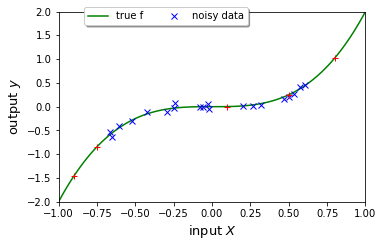

In [4]:
var_n = 0.05 ** 2
f = lambda x, noisy: 2 * x ** 3 + noisy*np.sqrt(var_n)*np.random.normal(size=x.shape)
n_data = 20
xn = np.array([-0.02519606, -0.29152739, -0.60474655, 0.31944225, -0.08100553, -0.24830156, 0.57461577, 
               0.50232181, 0.60433894, -0.02046175, 0.53479088, -0.65367602, -0.06110107, 0.46652892, 
               -0.66163461, 0.26793157, 0.20481661, -0.24144274, -0.42398829, -0.52080597]).reshape((-1, 1))
yn = np.array([0.04928457864952569, -0.11915410490457669, -0.405097551770553, 0.029554098140267056, 
               -0.013086956159543405, -0.017770100521146612, 0.42280077037504055, 0.1944984572601308, 
               0.4534092801344878, -0.05744532400253988, 0.27416952296635494, -0.6450129511010473, 
               -0.00434618253501617, 0.16330603887330705, -0.5274704221475347, 0.02189741180766931, 
               0.012647796994763167, 0.08367359752673682, -0.10875986459325471, 
               -0.2964629150726794]).reshape((-1, 1))
x_plot = np.linspace(-1, 1, 100).reshape((-1,1))
y_plot = f(x_plot, False)

fig, ax = plt.subplots(figsize=(5.5,3.5), ncols=1)
ax.plot(x_plot, f(x_plot, False), **kwargs_true_f)
ax.plot(xn, yn, **kwargs_data)
set_labels(ax); set_axis_limits(ax)
plt.legend(loc='upper center', bbox_to_anchor=(0.35, 1.05), ncol=2, fancybox=True, shadow=True)

x_sub = np.array([-0.9, -0.75, 0.1, 0.5, 0.8]).reshape((-1, 1))
ax.plot(x_sub, f(x_sub, noisy=False), linestyle='none', marker='+', color='red')
plt.show()

training_dict = {'epochs': 5000, 'lr': 0.005, 'ns': 20}

### Get results from MCMC run

In [5]:
import pickle
folder = '/Users/audreyolivier/Data/UQ_in_ML_MCMC_runs/'
with open(folder+'cubic_March20_0_bis.pkl', 'rb') as f:
    mcmc_dict = pickle.load(f)

from UQ_in_ML.epistemic_regressors_mcmc import MCMCRegressor
var_n, xn, yn, x_monitoring = mcmc_dict['var_n'], mcmc_dict['xn'], mcmc_dict['yn'], mcmc_dict['x_monitoring']
reg = MCMCRegressor(algorithm=mcmc_dict['algorithm'], jump=mcmc_dict['jump'], nburn=mcmc_dict['nburn'], 
    **mcmc_dict['nn'])
reg.fit(X=xn, y=yn, nsamples_per_chain=0)
reg.mcmc_sampler.samples = mcmc_dict['samples'][-5:, :, :].reshape((-1, reg.dimension))
print(mcmc_dict['samples'].shape)

y_mean, y_std, y_perc = reg.predict_uq(
    X=x_sub, return_std=True, return_percentiles=(2.5, 97.5), return_MC=0, aleatoric_in_std_perc=True)
width1_mcmc = 4 * y_std[:, 0]    # twice 2 * std
width2_mcmc = y_perc[1, :, 0] - y_perc[0, :, 0]    # width of the 95% confidence interval
print(width1_mcmc)
print(width2_mcmc)

Using TensorFlow backend.


(20, 602, 301)
[1.97687586 0.77194083 0.39163554 0.25458688 1.67241526]
[1.97263254 0.74165914 0.38410668 0.25386265 1.67682876]


## Set network

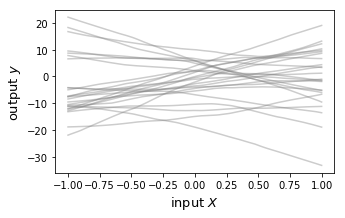

In [6]:
nn = {'input_dim': 1, 
      'output_dim': 1,
      'var_n': var_n,
      'hidden_units': (100,),
      'activation': tf.nn.relu,
      'prior_means': 0.,
      'prior_stds': 1.}
weights_to_track = [] # track 5 kernel weights in each uq layer, and no bias
[weights_to_track.extend([5, 0]) for j in range(len(nn['hidden_units']) + 1)]

fig, ax = plt.subplots(figsize=(5, 3))
reg = Regressor(**nn)
y_MC = reg.predict_uq_from_prior(X=x_plot, ns=25)
plot_mean_MC(x_plot, y_MC, ax)
set_labels(ax)
plt.show()

# Part 1: BayesByBackprop vs. alpha BB

First, check wether using analytical grads reduces computational time. Yep for BayesByBackprop, not really for alphaBB.

6.223328113555908


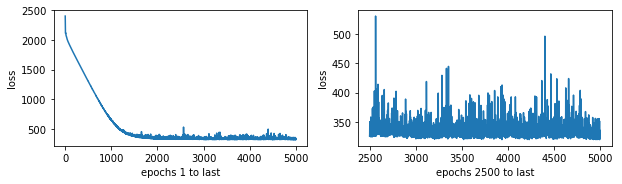

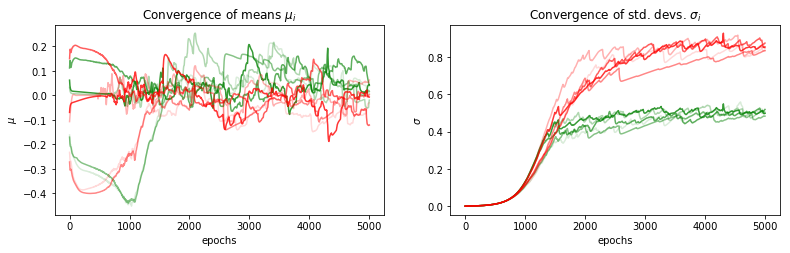

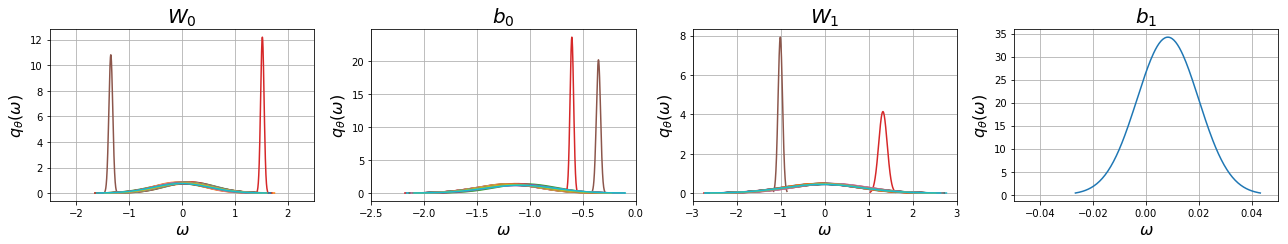

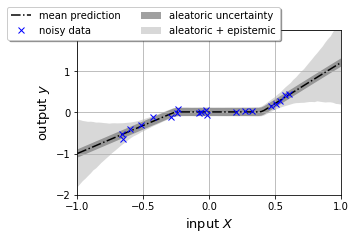

In [26]:
reg_0 = BayesByBackprop(weights_to_track=weights_to_track, analytical_grads=True, **nn)
t0 = time.time()
reg_0.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
fig1, fig2 = plot_results_vi(reg_0)
#fig1.savefig('cubic_BbB_posterior.pdf')
#fig2.savefig('cubic_BbB_prediction.pdf')

15.888836860656738


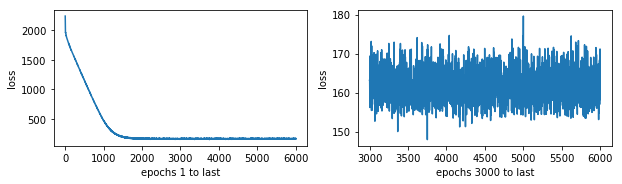

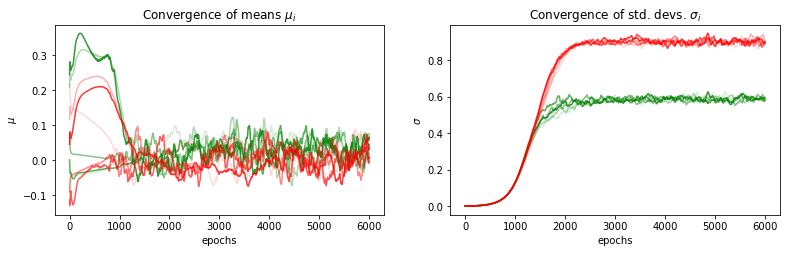

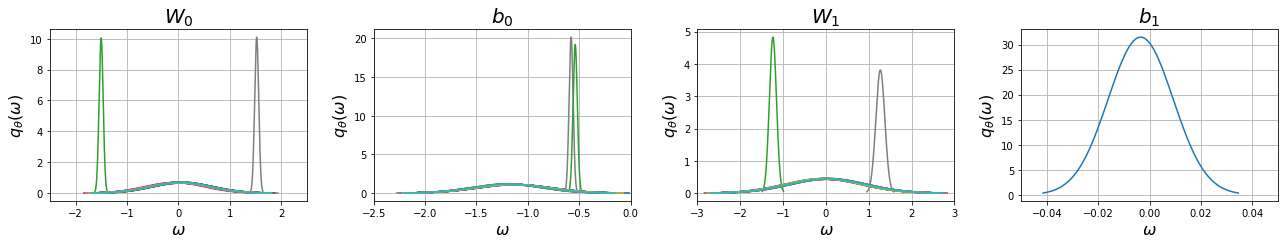

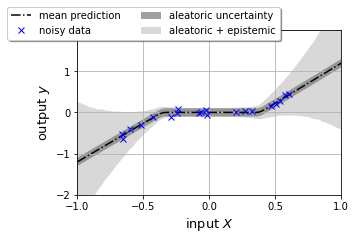

(<Figure size 1296x252 with 4 Axes>, <Figure size 360x252 with 1 Axes>)

In [21]:
t0 = time.time()
reg_1 = alphaBB(alpha=0.1, weights_to_track=weights_to_track, **nn)
reg_1.fit(X=xn, y=yn, **training_dict)
print(time.time()-t0)
plot_results_vi(reg_1)

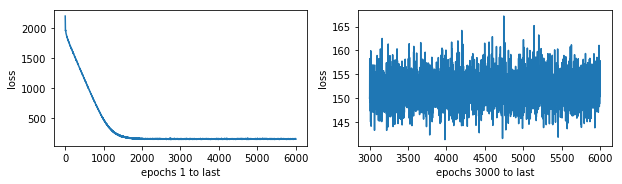

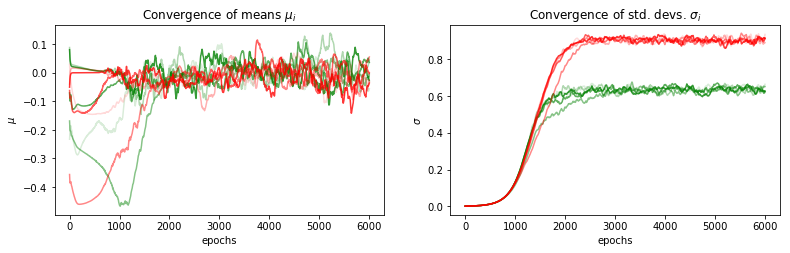

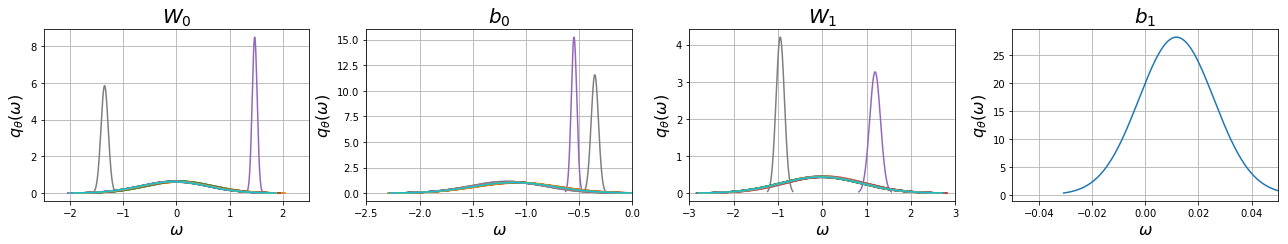

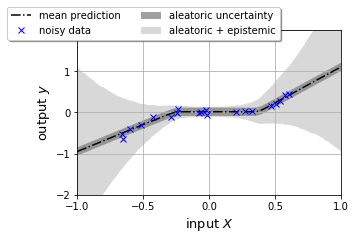

(<Figure size 1296x252 with 4 Axes>, <Figure size 360x252 with 1 Axes>)

In [22]:
reg_2 = alphaBB(alpha=0.2, weights_to_track=weights_to_track, **nn)
reg_2.fit(X=xn, y=yn, **training_dict)
plot_results_vi(reg_2)

# Part 2: Add correlation

## BayesByBackprop - via A matrix

6.784073114395142


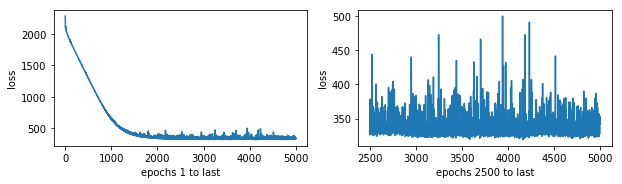

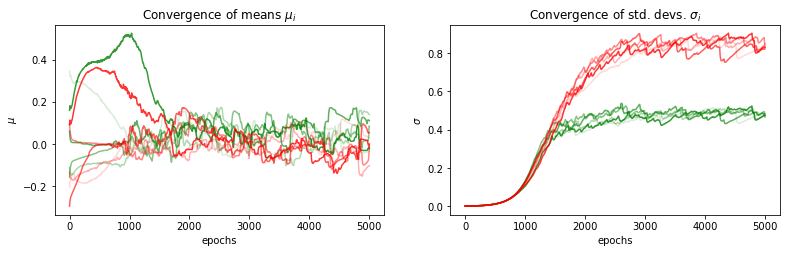

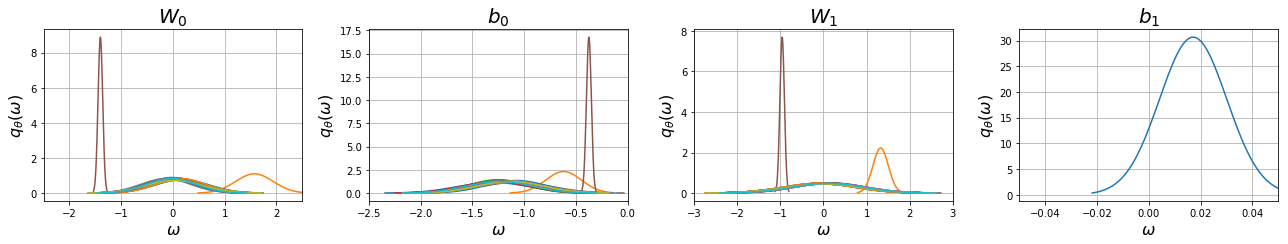

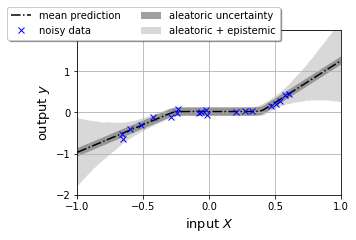

(<Figure size 1296x252 with 4 Axes>, <Figure size 360x252 with 1 Axes>)

In [24]:
t0 = time.time()
reg_0 = BayesByBackpropLowRank(rank=2, weights_to_track=weights_to_track, analytical_grads=True, **nn)
reg_0.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
plot_results_vi(reg_0)

7.393265962600708


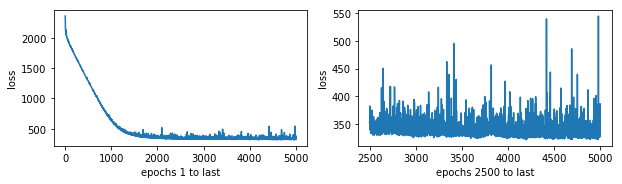

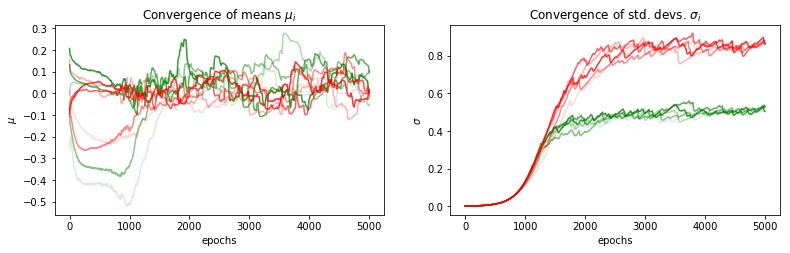

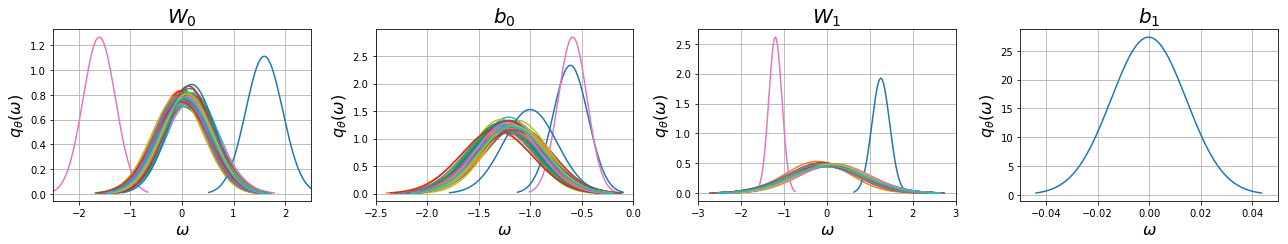

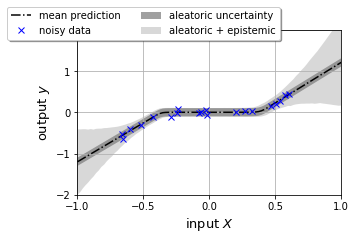

In [27]:
t0 = time.time()
reg_0 = BayesByBackpropLowRank(rank=5, weights_to_track=weights_to_track, analytical_grads=True, **nn)
reg_0.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
fig1, fig2 = plot_results_vi(reg_0)
#fig1.savefig('cubic_BbB_posterior_Amat.pdf')
#fig2.savefig('cubic_BbB_prediction_Amat.pdf')

13.346247911453247


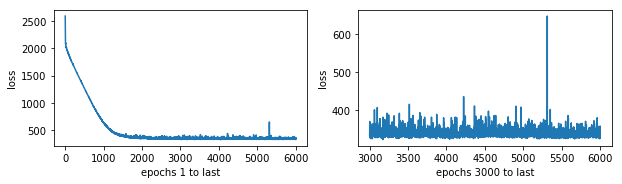

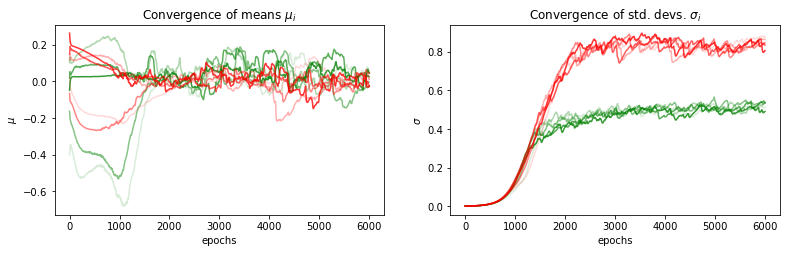

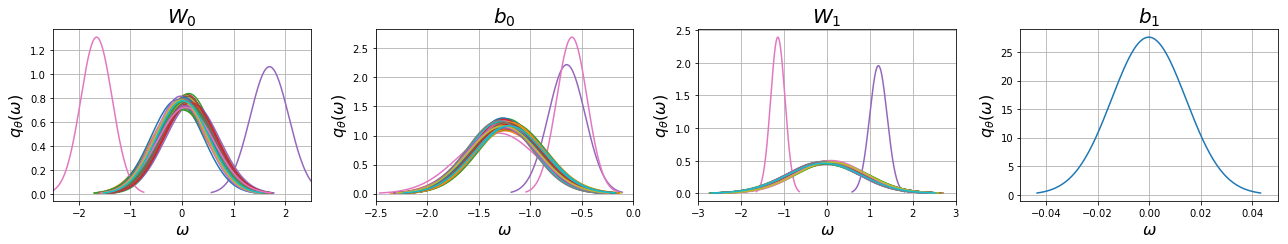

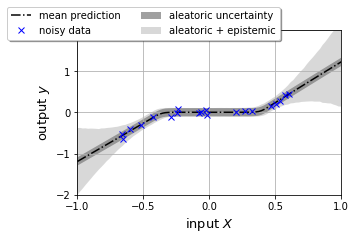

(<Figure size 1296x252 with 4 Axes>, <Figure size 360x252 with 1 Axes>)

In [28]:
t0 = time.time()
reg_0 = BayesByBackpropLowRank(rank=10, weights_to_track=weights_to_track, analytical_grads=True, **nn)
reg_0.fit(X=xn, y=yn, epochs=6000, lr=0.005, ns=50)
print(time.time() - t0)
plot_results_vi(reg_0)

Do it several times and compare with MCMC

RANK = 0
27.416903972625732


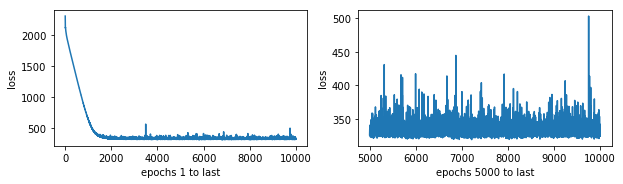

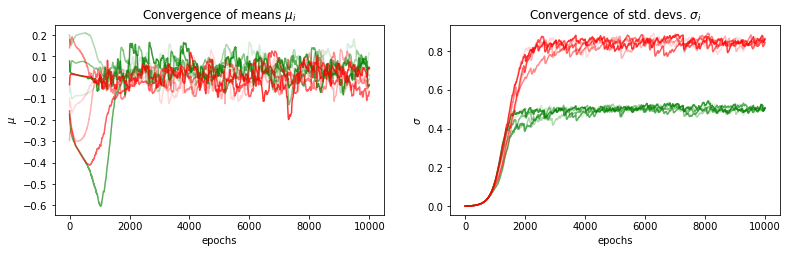

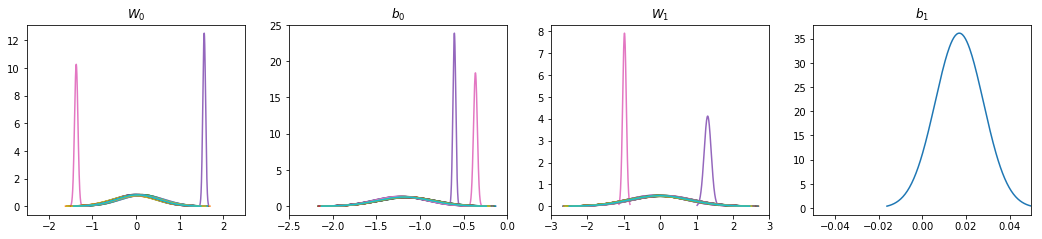

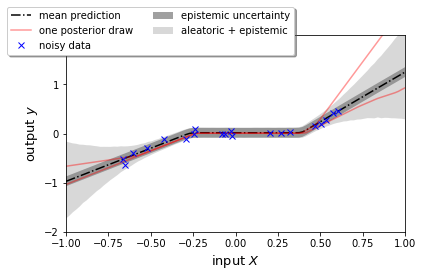

RANK = 5
25.93314003944397


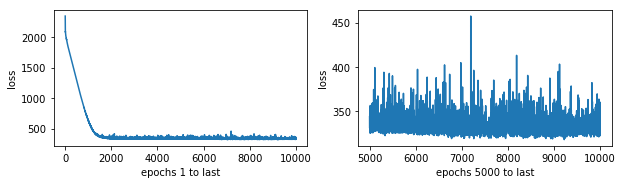

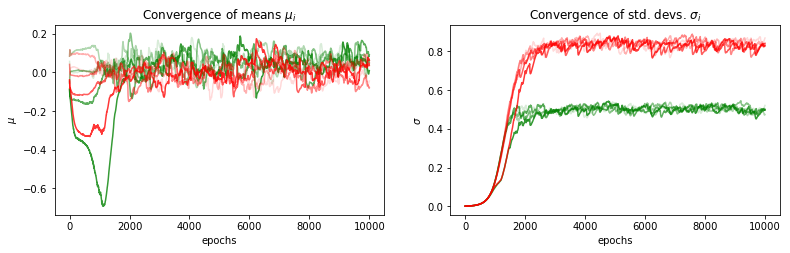

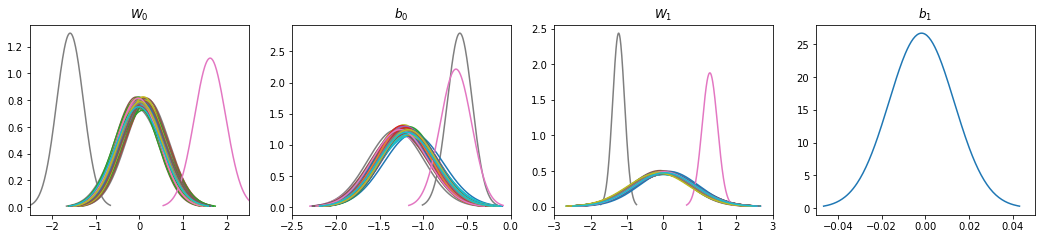

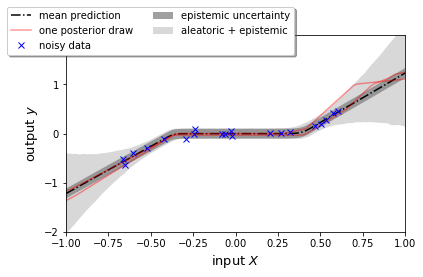

RANK = 10
36.145437240600586
RANK = 15
36.987611293792725
RANK = 20
51.680010080337524


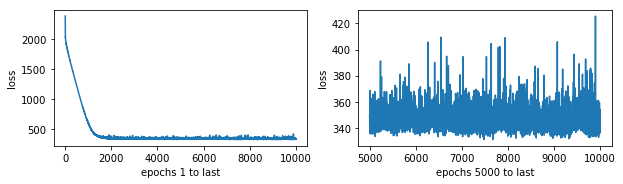

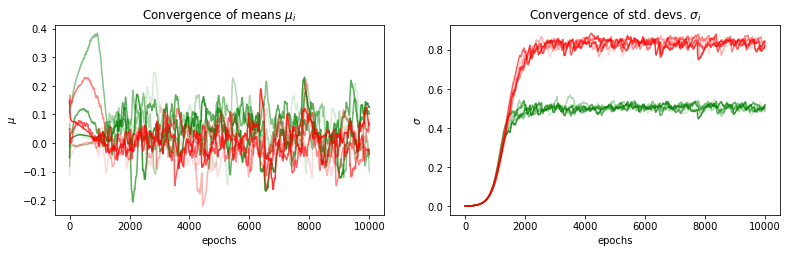

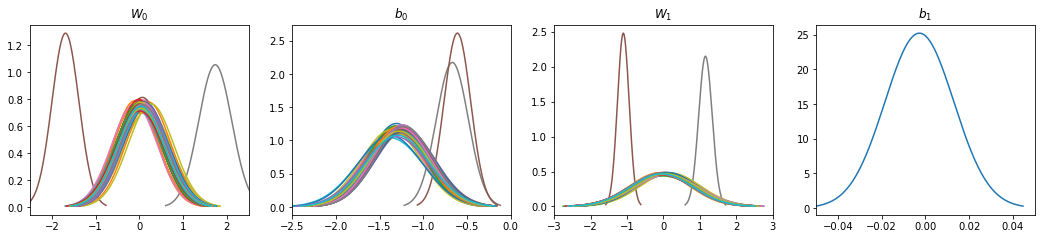

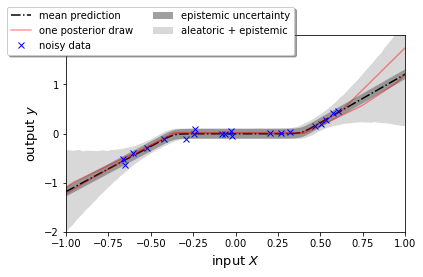

RANK = 25
48.43894290924072
RANK = 30
50.92650270462036
RANK = 35
57.11755609512329
RANK = 40
53.915613889694214
RANK = 45
86.5184919834137
RANK = 50
94.56632900238037


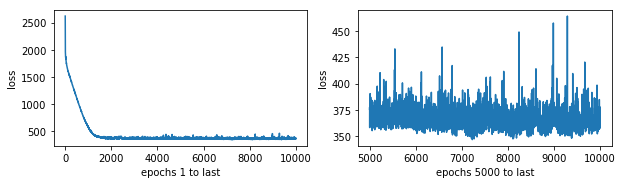

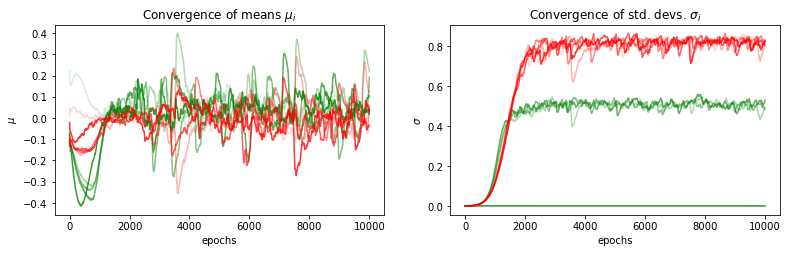

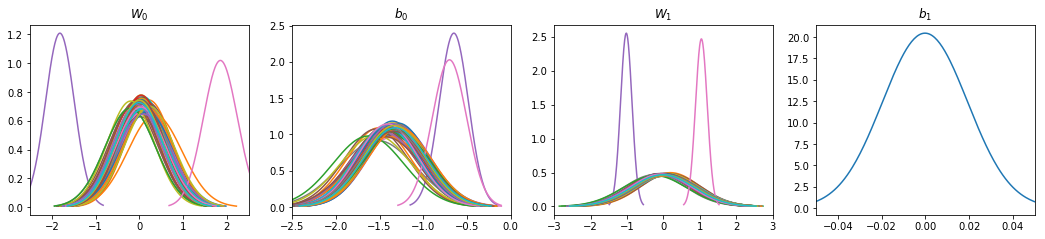

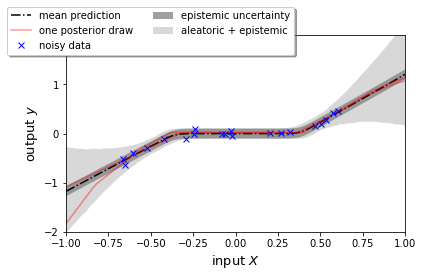

RANK = 55
82.85786199569702
RANK = 60
75.74285197257996
RANK = 65
78.93534803390503
RANK = 70
85.66219067573547
RANK = 75
86.72609376907349
RANK = 80
127.55464196205139
RANK = 85
151.14147996902466
RANK = 90
156.19731521606445
RANK = 95
165.19979190826416
RANK = 100
170.27516078948975


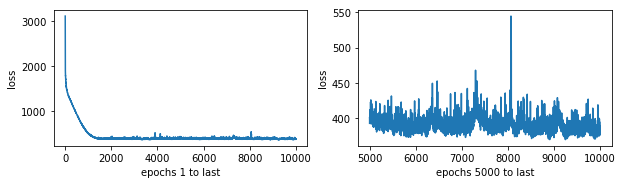

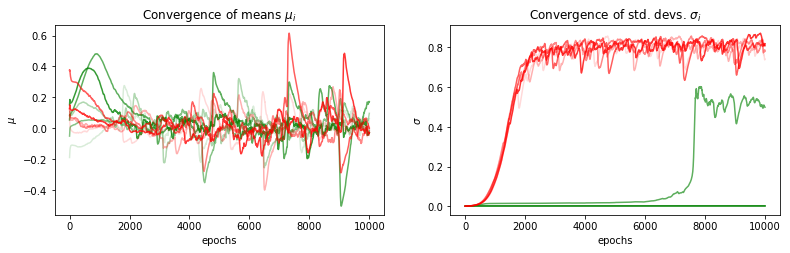

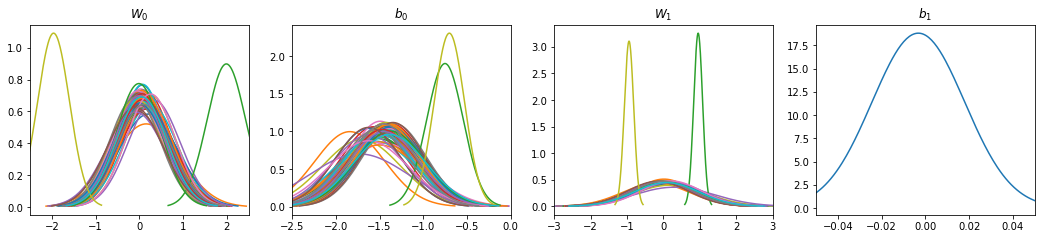

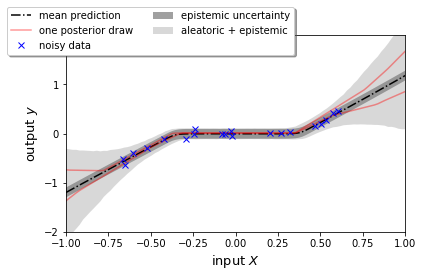

RANK = 105
178.378191947937
RANK = 110
196.02499198913574
RANK = 115
206.85859203338623
RANK = 120
217.12277102470398
RANK = 125
187.0429401397705
RANK = 130
183.06461691856384
RANK = 135
189.81440591812134
RANK = 140
165.40018105506897
RANK = 145
196.4752299785614
RANK = 150
211.62158584594727


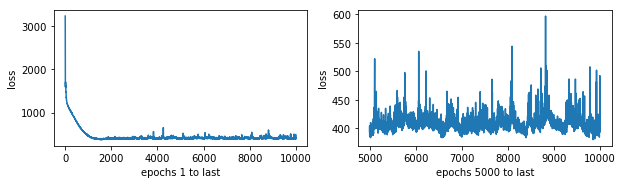

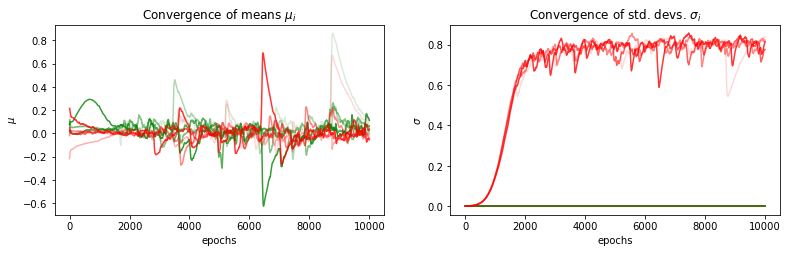

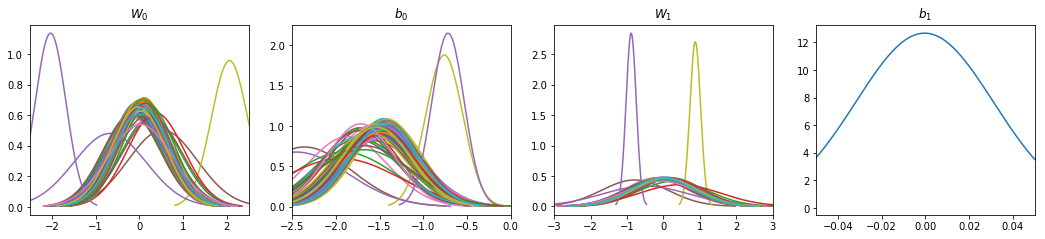

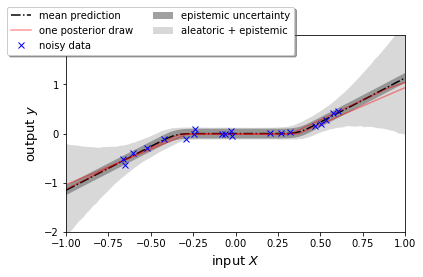

RANK = 155
198.00317883491516
RANK = 160
191.2312912940979
RANK = 165
183.6036422252655
RANK = 170
193.8465359210968
RANK = 175
204.54582405090332
RANK = 180
210.958270072937
RANK = 185
211.47560906410217
RANK = 190
219.6999750137329
RANK = 195
219.99453210830688
RANK = 200
222.87620782852173


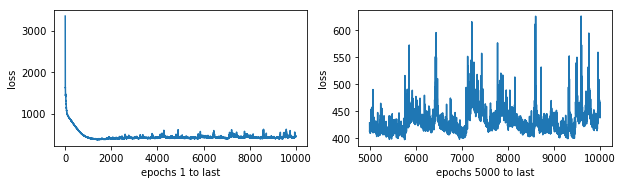

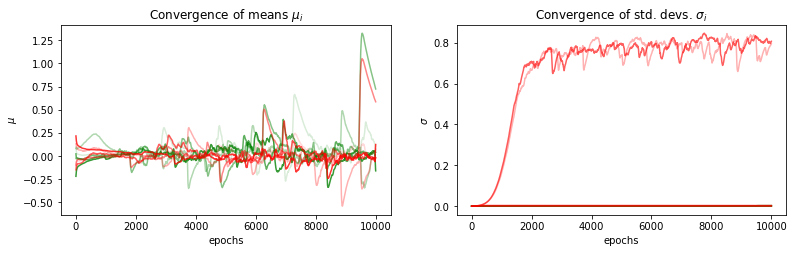

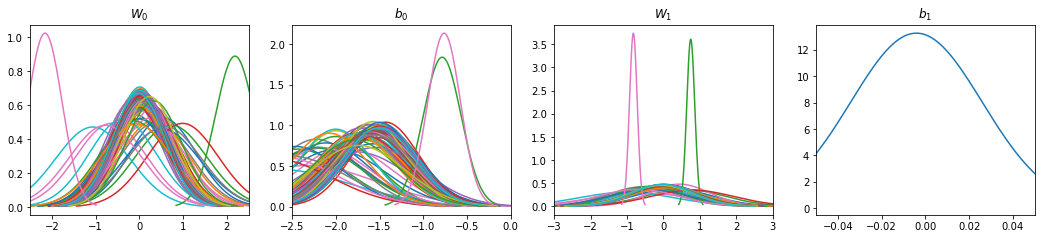

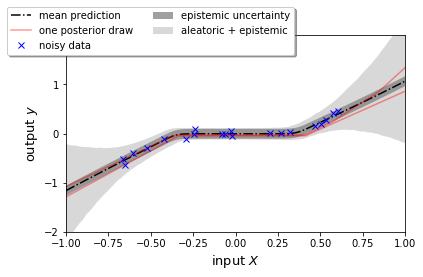

In [7]:
uq_results = []
for rank in np.arange(0, 201, 5):
    print('RANK = {}'.format(rank))

    t0 = time.time()
    if rank == 0:
        reg_0 = BayesByBackprop(weights_to_track=weights_to_track, analytical_grads=True, **nn)
    else:
        reg_0 = BayesByBackpropLowRank(rank=rank, weights_to_track=weights_to_track, analytical_grads=True, **nn)
    reg_0.fit(X=xn, y=yn, epochs=10000, lr=0.005, ns=50 + 3 * rank)
    print(time.time() - t0)

    widths = plot_results_vi(reg_0, do_plots=(rank in [0, 5, 20, 50, 100, 150, 200]), return_width=True)
    uq_results.append(widths)

[1.97687586 0.77194083 0.39163554 0.25458688 1.67241526]


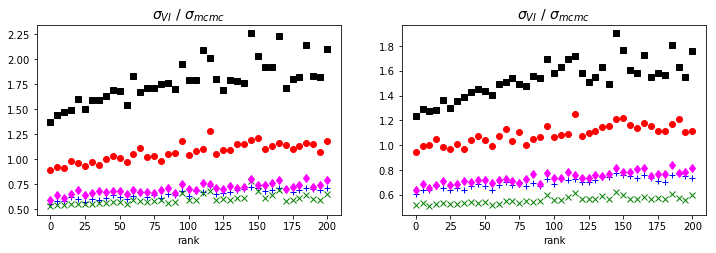

In [11]:
ranks = np.arange(0, 201, 5)
markers = ['+', 'o', 'x', 's', 'd']
colors = ['blue', 'red', 'green', 'black', 'magenta']
print(width1_mcmc)

uq_results = np.array(uq_results)
fig, ax = plt.subplots(ncols=2, figsize=(12, 3.5))
for i, w_mcmc in enumerate(width1_mcmc):
    ax[0].plot(ranks, uq_results[:, 0, i]/w_mcmc, marker=markers[i], color=colors[i], linestyle='none')
for i, w_mcmc in enumerate(width2_mcmc):
    ax[1].plot(ranks, uq_results[:, 1, i]/w_mcmc, marker=markers[i], color=colors[i], linestyle='none')
ax[0].set_title(r'$\sigma_{VI}$ / $\sigma_{mcmc}$', fontsize=14)
ax[1].set_title(r'$\sigma_{VI}$ / $\sigma_{mcmc}$', fontsize=14)
ax[0].set_xlabel('rank')
ax[1].set_xlabel('rank')
plt.show()

In [14]:
uq_means = []
uq_percs = []
for rank in [0, 5, 50, 100, 200]:
    print('RANK = {}'.format(rank))

    t0 = time.time()
    if rank == 0:
        reg_0 = BayesByBackprop(weights_to_track=weights_to_track, analytical_grads=True, **nn)
    else:
        reg_0 = BayesByBackpropLowRank(rank=rank, weights_to_track=weights_to_track, analytical_grads=True, **nn)
    reg_0.fit(X=xn, y=yn, epochs=10000, lr=0.005, ns=50 + 3 * rank)
    print(time.time() - t0)
    
    y_mean, y_perc = reg_0.predict_uq(
        X=x_plot, ns=10000, return_std=False, return_percentiles=(2.5, 97.5), return_MC=0, 
        aleatoric_in_std_perc=True, aleatoric_in_MC=False)
    uq_means.append(y_mean)
    uq_percs.append(y_perc)

RANK = 0
22.8883318901062
RANK = 5
24.959854125976562
RANK = 50
65.65217399597168
RANK = 100
108.30492687225342
RANK = 200
219.92370104789734


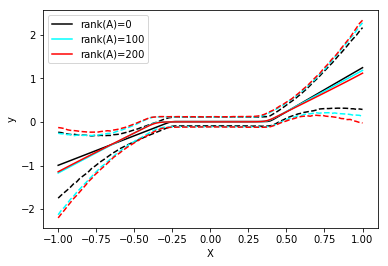

In [24]:
ranks = [0, 5, 50, 100, 200]
colors = ['black', 'blue', 'green', 'cyan', 'red']
fig, ax = plt.subplots()
for i, rank in enumerate([0, 5, 50, 100, 200]):
    if rank in [0, 100, 200]:
        ax.plot(x_plot, uq_means[i][:, 0], color=colors[i], label='rank(A)={}'.format(rank))
        ax.plot(x_plot, uq_percs[i][0, :, 0], color=colors[i], linestyle='--')
        ax.plot(x_plot, uq_percs[i][1, :, 0], color=colors[i], linestyle='--')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('y')
plt.show()

## Correlation via correlation coefficients

14.332840919494629
Training error = 0.04835184537924245


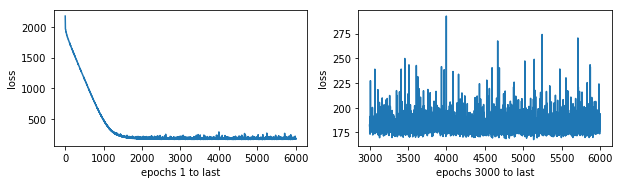

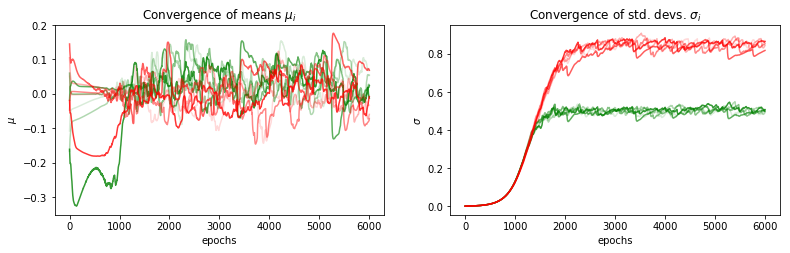

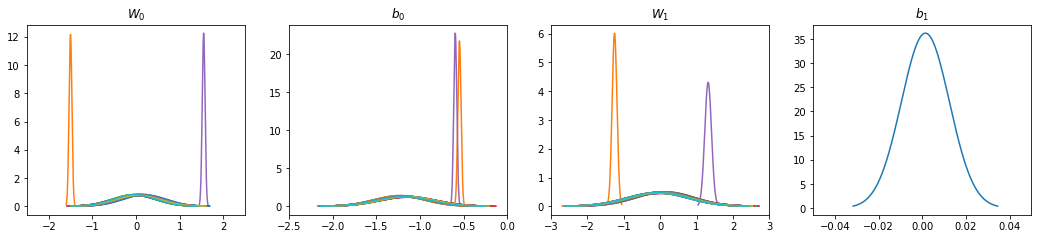

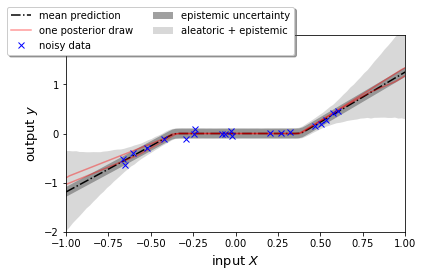

In [27]:
t0 = time.time()
reg_0 = BayesByBackpropWithCorr(weights_to_track=weights_to_track, **nn)
reg_0.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
plot_results_vi(reg_0)

In [28]:
_, mask_correlation = reg_0.rank_network_weights(
    rank_metric='information gain', return_mask=True, threshold_on_number=(2, 2, 2, 1), per_layer_=True)

Training error = 0.04867832903604965


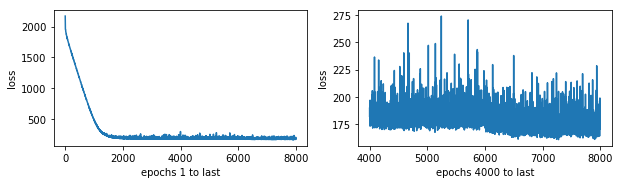

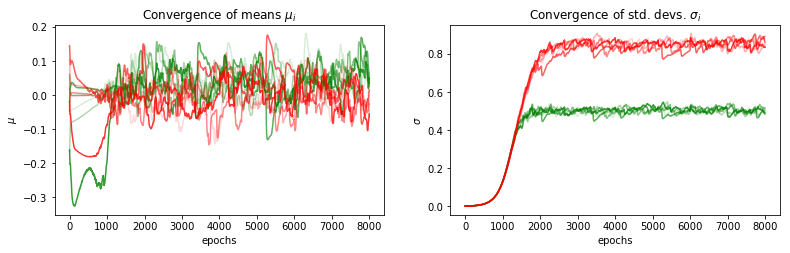

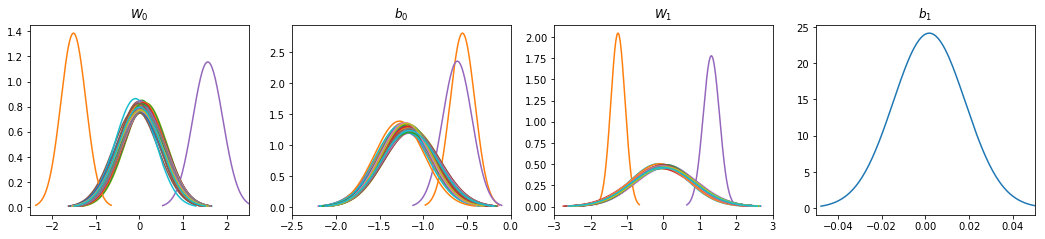

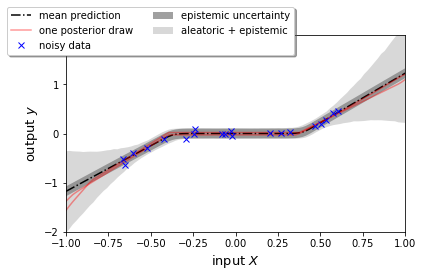

In [29]:
reg_0.add_correlation(mask_correlation=mask_correlation)
reg_0.fit(X=xn, y=yn, epochs=2000, lr=0.005, ns=50)
plot_results_vi(reg_0)

## Add correlation to alphaBB algorithm via A matrix

15.229820966720581


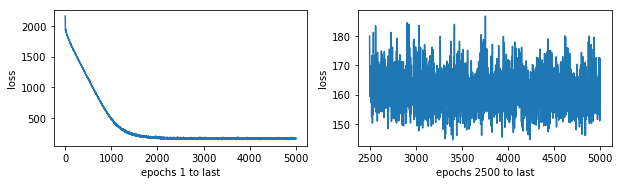

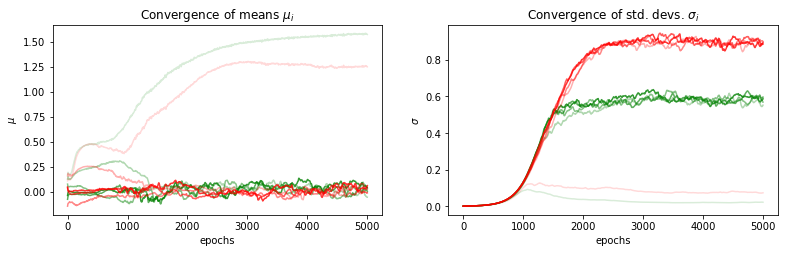

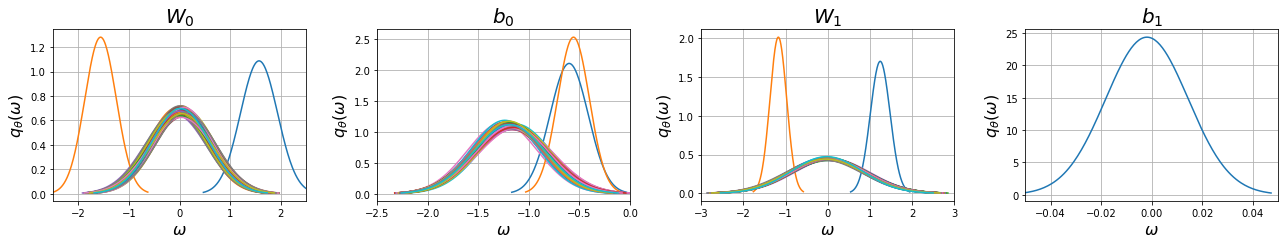

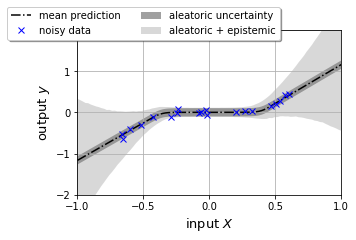

(<Figure size 1296x252 with 4 Axes>, <Figure size 360x252 with 1 Axes>)

In [32]:
t0 = time.time()
reg_0 = alphaBBLowRank(alpha=0.1, rank=5, weights_to_track=weights_to_track, **nn)
reg_0.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
plot_results_vi(reg_0)

# Part 3: mixture of Gaussians

14.84280800819397


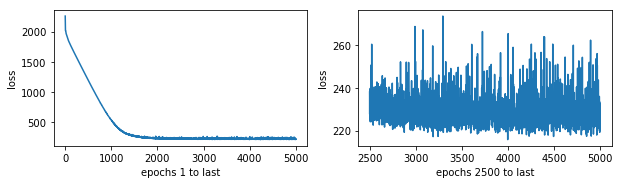

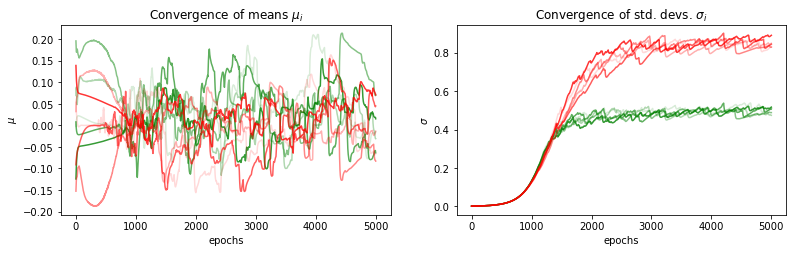

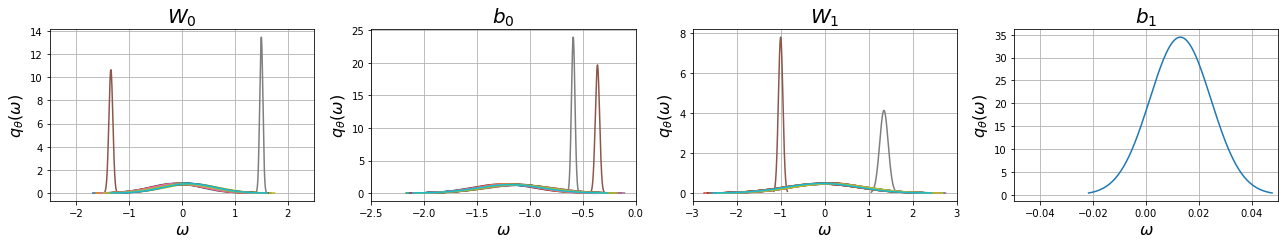

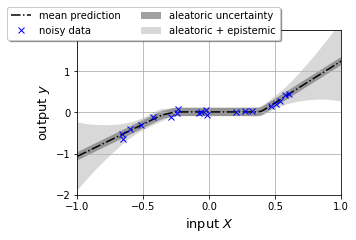

In [34]:
reg_m = BayesByBackpropMixture(weights_to_track=weights_to_track, ncomp=5, lower_bound=True, **nn)
t0 = time.time()
reg_m.fit(X=xn, y=yn, **training_dict)
print(time.time() - t0)
fig1, fig2 = plot_results_vi(reg_m)
#fig2.savefig('cubic_mixture.pdf')